In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SVR,
    SVR_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.split import get_n_splits
from src.survival_function_wrapper import SurvivalFunctionWrapper
from src.wrapper import ScikitLearnWrapper, SkipCutOffScikitLearnWrapper
from src.xgb_wrapper import XGBwrapper

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
PERMUATION_LOGNORMAL_MEAN_SIGMA = (0, 1)

In [4]:
N_TRIALS = 500
N = 3
INSTANCE_NUMBER = 10
SOLVER_NUMBER = 90
RANDOM_STATE = 0

SPLITS = get_n_splits(
    df=df,
    n=N,
    instance_number=INSTANCE_NUMBER,
    solver_number=SOLVER_NUMBER,
    random_state=RANDOM_STATE,
)

### Ridge

In [5]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# ridge_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=Ridge,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=RIDGE_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 20 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 50e02f as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config ef53c2 and rejected config 50e02f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 0f603d and rejected config ef53c2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 34e9a1 and rejected config 0f603d as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config adf2ff and rejected config 34e9a1 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 976d32 and rejecte

### PolynomialRidge

In [6]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=PolynomialRidge,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=POLY_RIDGE_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0f550a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config a3d22f and rejected config 0f550a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config ccf945 and rejected config a3d22f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 6db2ea and rejected config ccf945 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config e3fdbb and rejected config 6db2ea as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 6d8c5d and rejecte

### RandomForestRegressor

In [7]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# rf_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=RandomForestRegressor,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=RANDOM_FOREST_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 70 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config f8a6b5 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 286ac7 and rejected config f8a6b5 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 4ef6d2 and rejected config 286ac7 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 3b886b and rejected config 4ef6d2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config cbf571 and rejected config 3b886b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config def282 and rejecte

### XGBRegressor

In [8]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# xgb_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=XGBRegressor,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=XGB_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 100 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0610fc as new incumbent because there are no incumbents yet.
[INFO][smbo.py:320] Finished 50 trials.
[INFO][smbo.py:320] Finished 100 trials.
[INFO][smbo.py:320] Finished 150 trials.
[INFO][smbo.py:320] Finished 200 trials.
[INFO][smbo.py:320] Finished 250 trials.
[INFO][smbo.py:320] Finished 300 trials.
[INFO][smbo.py:320] Finished 350 trials.
[INFO][smbo.py:320] Finished 400 trials.
[INFO][smbo.py:320] Finished 450 trials.
[INFO][smbo.py:320] Finished 500 trials.
[INFO][smbo.py:328] Configuration budget is exhausted:
[INFO][smbo.py:329] --- Remaining wallclock time: inf
[INFO][smbo.py:330] --- Remaining cpu time: inf
[INFO][smbo.py:331] --- Remaining trials: 0


### SVR

In [9]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# svr_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=SVR,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=SVR_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 60 initial design configurations and 0 additional configurations.


[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 383a37 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config d88a62 and rejected config 383a37 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 0b608a and rejected config d88a62 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 91ed73 and rejected config 0b608a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config b18e61 and rejected config 91ed73 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 8c7c76 and rejected config b18e61 as incumbent because it is not better than the incumben

### GPRWithRBF

In [10]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)

# gpr_incumbent_skip_cutoff = optimize_hyperparameters(
#     df=df,
#     model_cls=GPRWithRBF,
#     wrapper_cls=SkipCutOffScikitLearnWrapper,
#     configspace=GPR_CONFIGSPACE,
#     splits=SPLITS,
#     random_state=RANDOM_STATE,
#     n_trials=N_TRIALS,
#     permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
# )

[INFO][abstract_initial_design.py:147] Using 30 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 0b9b43 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 3442b9 and rejected config 0b9b43 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 3e3a31 and rejected config 3442b9 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 06afb9 and rejected config 3e3a31 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 1c73bb and rejected config 06afb9 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier

### CoxPHSurvivalAnalysis

In [11]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)
coxph_incumbent

[INFO][abstract_initial_design.py:147] Using 50 initial design configurations and 0 additional configurations.


[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 2f56c8 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config adb80f and rejected config 2f56c8 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 3eb353 and rejected config adb80f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config af6701 and rejected config 3eb353 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 24e32a and rejected config af6701 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 03b228 and rejected config 24e32a as incumbent because it is not better than the incumben

{'alpha': 13.6880493422333,
 'risk_function': 'polynomial',
 'ties': 'breslow',
 'risk_alpha': 0.553369716052,
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [12]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)
rsf_incumbent

[INFO][abstract_initial_design.py:147] Using 90 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 20fae2 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config 451903 and rejected config 20fae2 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config a39154 and rejected config 451903 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 9cedd1 and rejected config a39154 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 9b33e1 and rejected config 9cedd1 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 41a44a and rejecte

{'max_depth': 6,
 'max_features': 0.9824992947894,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'exponential',
 'risk_alpha': 1.8584129523055,
 'risk_beta': 187.166074575589,
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [13]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)
gb_cox_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 130 to 125 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 125 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 7e620a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config a1191f and rejected config 7e620a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 05d4b3 and rejected config a1191f as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 50 trials.
[INFO][abstract_intensifier.py:595] Added config 4db2ed and rejected config 05d4b3 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:320] Finished 100 trials.
[INFO][abstract_inten

{'ccp_alpha': 0.0023850197557,
 'learning_rate': 0.2319669631084,
 'loss': 'coxph',
 'max_depth': 5,
 'max_features': 0.7194957289126,
 'min_samples_leaf': 32,
 'min_samples_split': 5,
 'n_estimators': 472,
 'random_state': 0,
 'risk_function': 'polynomial',
 'subsample': 0.6286117496721,
 'risk_alpha': 0.8009472438586,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [14]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    random_state=RANDOM_STATE,
    n_trials=N_TRIALS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
)
xgb_aft_incumbent

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 140 to 125 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 125 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:516] Added config 1f402b as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:595] Added config e58b16 and rejected config 1f402b as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 38ddd0 and rejected config e58b16 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config b121f9 and rejected config 38ddd0 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][abstract_intensifier.py:595] Added config 3db4a5 and rejected config b121f9 as incumbent becaus

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.6298013597726,
 'eval_metric': 'aft-nloglik',
 'gamma': 2.5000043394916,
 'learning_rate': 0.0732260708093,
 'max_depth': 3,
 'min_child_weight': 5,
 'num_boost_round': 627,
 'objective': 'survival:aft',
 'reg_alpha': 0.0059666994075,
 'reg_lambda': 0.0012793868001,
 'seed': 0,
 'subsample': 0.5567903424362,
 'aft_loss_distribution_scale': 0.7159987670782,
 'model_cls': src.configspace.XGBRegressorAFT}

## Comparison

In [15]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
    #     "name": "Ridge Regression"
    # },
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
    #     "name": "Polynomial Regression"
    # },
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
    #     "name": "Support Vector Regression"
    # },
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
    #     "name": "Gaussian Process Regression"
    # },
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
    #     "name": "Random Forest"
    # },
    # {
    #     "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
    #     "name": "XGBoost"
    # },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
]
 
random_state_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# random_state_list = [1]
solver_number_list = [5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 300, 500]
total_iterations = len(random_state_list) * len(solver_number_list) * len(model_info_list)
pbar = tqdm(total=total_iterations, desc="Evaluating models")

records = []

for random_state in random_state_list:
    for solver_number in solver_number_list:
        pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
        splits = get_n_splits(
            df,
            n=5,
            instance_number=10,
            solver_number=solver_number,
            random_state=random_state,
        )
        for model_info in model_info_list:
            pbar.set_postfix(model=model_info["name"])

            result = evaluate_model_with_cross_validation(
                df,
                wrapper=model_info["wrapper"],
                splits=splits,
                permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
                random_state=random_state,
            )
            result["random_state"] = random_state
            result["solver_number"] = solver_number
            result["name"] = model_info["name"]
            records.append(result)
            pbar.update(1)

pbar.close()
result_df = pd.DataFrame(records)

Evaluating models:   0%|          | 0/2400 [00:00<?, ?it/s]

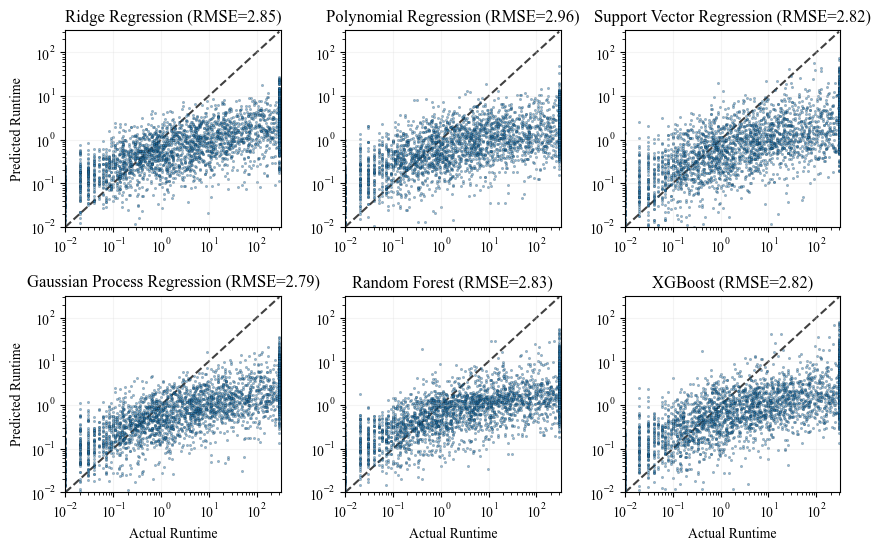

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[:6].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')
    # ax.axhline(y=1, color='red', linestyle='--')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
axs[5].set_xlabel("Actual Runtime")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
_ = pd.read_pickle("tobit_permutation.pkl")

result_df = pd.concat([result_df, _], axis=0).reset_index(drop=True)

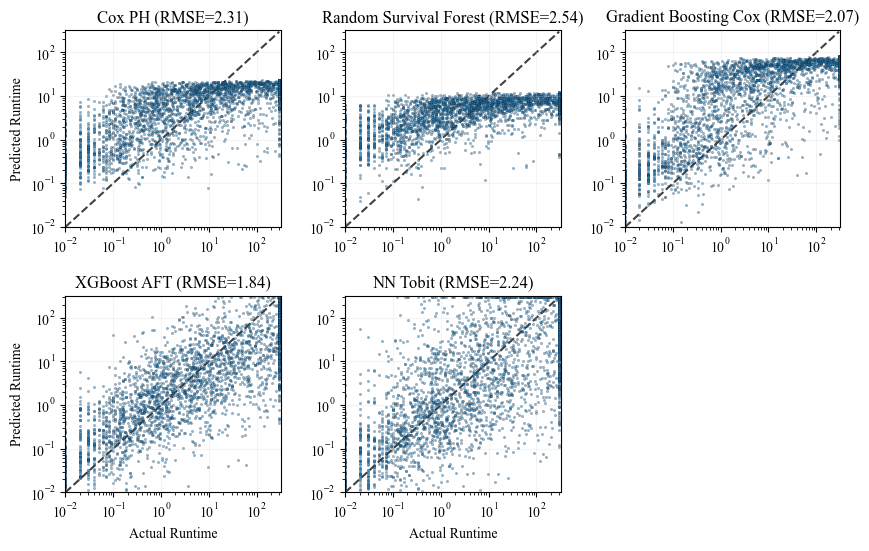

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axs = axs.flatten()

plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[6:12].reset_index(drop=True)

for i, result in plot_df.iterrows():
    ax = axs[i]

    sc = ax.scatter(
        result["y_test_not_censored"],
        result["y_pred"],
        alpha=0.5,
        edgecolors="k",
        lw=0.2,
        s=3,
    )
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlim(0.01, 320)
    ax.set_ylim(0.01, 320)
    ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
    ax.set_title(f'{result["name"]} (RMSE={result["rmse"]:.2f})')

axs[0].set_ylabel("Predicted Runtime")
axs[3].set_ylabel("Predicted Runtime")
axs[3].set_xlabel("Actual Runtime")
axs[4].set_xlabel("Actual Runtime")
# axs[5].set_xlabel("Actual Runtime")
axs[5].axis("off")
plt.subplots_adjust(wspace=0.3, hspace=0.35)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

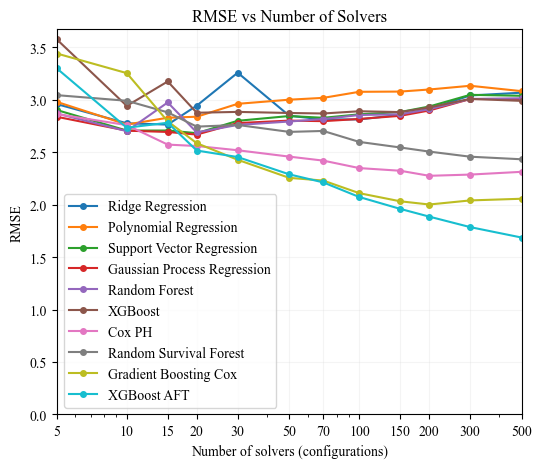

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))

plot_df = result_df.groupby(["name", "solver_number"], sort=False)["rmse"].mean().reset_index()

for name, group in plot_df.groupby("name", sort=False):
    plt.plot(
        group['solver_number'], 
        group['rmse'], 
        'o-', 
        label=name,
        linewidth=1.5,
         markersize=4
    )

plt.xscale('log')
plt.xlabel('Number of solvers (configurations)')
plt.ylabel('RMSE')
plt.legend(loc='best', frameon=True)
plt.xticks(plot_df['solver_number'].unique(), plot_df['solver_number'].unique())
plt.title('RMSE vs Number of Solvers')
plt.ylim(0)
plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [30]:
result_df.pivot_table(
    columns="solver_number",
    index="name",
    values="rmse",
).to_excel("comparison_permutation.xlsx")